In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
import os 
from datetime import datetime

# show all the output 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Step1: Define Help Functions:

### 1. Help Fucntions for Downloading and Importing Data

In [16]:
# %load ./cifar10.py
########################################################################
#
# Functions for downloading the CIFAR-10 data-set from the internet
# and loading it into memory.
#
# Implemented in Python 3.5
#
# Usage:
# 1) Set the variable data_path with the desired storage path.
# 2) Call maybe_download_and_extract() to download the data-set
#    if it is not already located in the given data_path.
# 3) Call load_class_names() to get an array of the class-names.
# 4) Call load_training_data() and load_test_data() to get
#    the images, class-numbers and one-hot encoded class-labels
#    for the training-set and test-set.
# 5) Use the returned data in your own program.
#
# Format:
# The images for the training- and test-sets are returned as 4-dim numpy
# arrays each with the shape: [image_number, height, width, channel]
# where the individual pixels are floats between 0.0 and 1.0.
#
########################################################################
#
# This file is part of the TensorFlow Tutorials available at:
#
# https://github.com/Hvass-Labs/TensorFlow-Tutorials
#
# Published under the MIT License. See the file LICENSE for details.
#
# Copyright 2016 by Magnus Erik Hvass Pedersen
#
########################################################################

import numpy as np
import pickle
import os
import urllib.request
import tarfile
import zipfile

########################################################################

# Directory where you want to download and save the data-set.
# Set this before you start calling any of the functions below.
data_path = "data/CIFAR-10/"

# URL for the data-set on the internet.
data_url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"

########################################################################
# Various constants for the size of the images.
# Use these constants in your own program.

# Width and height of each image.
img_size = 32

# Number of channels in each image, 3 channels: Red, Green, Blue.
num_channels = 3

# Length of an image when flattened to a 1-dim array.
img_size_flat = img_size * img_size * num_channels

# Number of classes.
num_classes = 10

########################################################################
# Various constants used to allocate arrays of the correct size.

# Number of files for the training-set.
_num_files_train = 5

# Number of images for each batch-file in the training-set.
_images_per_file = 10000

# Total number of images in the training-set.
# This is used to pre-allocate arrays for efficiency.
_num_images_train = _num_files_train * _images_per_file

########################################################################
# Private functions for downloading, unpacking and loading data-files.


def _get_file_path(filename=""):
    """
    Return the full path of a data-file for the data-set.
    If filename=="" then return the directory of the files.
    """

    return os.path.join(data_path, "cifar-10-batches-py/", filename)


def _unpickle(filename):
    """
    Unpickle the given file and return the data.
    Note that the appropriate dir-name is prepended the filename.
    """

    # Create full path for the file.
    file_path = _get_file_path(filename)

    print("Loading data: " + file_path)

    with open(file_path, mode='rb') as file:
        # In Python 3.X it is important to set the encoding,
        # otherwise an exception is raised here.
        data = pickle.load(file, encoding='bytes')

    return data

def ZCAtrans(raw):
    xm = np.mean(raw, axis = 0)
    raw= raw- xm
    raw2 = raw.reshape((raw.shape[0], -1))
    # raw is assumed to be zero-mean
    C = np.dot( raw2.T, raw2 )/raw2.shape[0]
    U, eva, V = np.linalg.svd(C)  # U[:, i] is the i-th eigenvector
    sqeva = np.sqrt(eva + 0.001)
    Uzca = np.dot(U/sqeva[np.newaxis, :], U.T)
    X = np.dot(raw2, Uzca)
    return X

def _convert_images(raw):
    """
    Convert images from the CIFAR-10 format and
    return a 4-dim array with shape: [image_number, height, width, channel]
    where the pixels are floats between 0.0 and 1.0.
    """

    # Convert the raw images from the data-files to floating-points.
    raw_float = np.array(raw, dtype=float) / 255.0
    raw_float = ZCAtrans(raw_float)

    # Reshape the array to 4-dimensions.
    images = raw_float.reshape([-1, num_channels, img_size, img_size])

    # Reorder the indices of the array.
    images = images.transpose([0, 2, 3, 1])
    
    # normailze each image
    for i in range(images.shape[0]):
        m,M = images[i].min(), images[i].max()
        images[i]=(images[i] - m) / (M - m)

    return images


def _load_data(filename):
    """
    Load a pickled data-file from the CIFAR-10 data-set
    and return the converted images (see above) and the class-number
    for each image.
    """

    # Load the pickled data-file.
    data = _unpickle(filename)

    # Get the raw images.
    raw_images = data[b'data']

    # Get the class-numbers for each image. Convert to numpy-array.
    cls = np.array(data[b'labels'])

    # Convert the images.
    images = _convert_images(raw_images)

    return images, cls


########################################################################
# Public functions that you may call to download the data-set from
# the internet and load the data into memory.


def maybe_download_and_extract(url, download_dir):
    """
    Download and extract the data if it doesn't already exist.
    Assumes the url is a tar-ball file.

    :param url:
        Internet URL for the tar-file to download.
        Example: "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"

    :param download_dir:
        Directory where the downloaded file is saved.
        Example: "data/CIFAR-10/"

    :return:
        Nothing.
    """

    # Filename for saving the file downloaded from the internet.
    # Use the filename from the URL and add it to the download_dir.
    filename = url.split('/')[-1]
    file_path = os.path.join(download_dir, filename)

    # Check if the file already exists.
    # If it exists then we assume it has also been extracted,
    # otherwise we need to download and extract it now.
    if not os.path.exists(file_path):
        # Check if the download directory exists, otherwise create it.
        if not os.path.exists(download_dir):
            os.makedirs(download_dir)

        # Download the file from the internet.
        file_path, _ = urllib.request.urlretrieve(url=url,
                                                  filename=file_path,
                                                  reporthook=_print_download_progress)

        print()
        print("Download finished. Extracting files.")

        if file_path.endswith(".zip"):
            # Unpack the zip-file.
            zipfile.ZipFile(file=file_path, mode="r").extractall(download_dir)
        elif file_path.endswith((".tar.gz", ".tgz")):
            # Unpack the tar-ball.
            tarfile.open(name=file_path, mode="r:gz").extractall(download_dir)

        print("Done.")
    else:
        print("Data has apparently already been downloaded and unpacked.")



def load_class_names():
    """
    Load the names for the classes in the CIFAR-10 data-set.
    Returns a list with the names. Example: names[3] is the name
    associated with class-number 3.
    """

    # Load the class-names from the pickled file.
    raw = _unpickle(filename="batches.meta")[b'label_names']

    # Convert from binary strings.
    names = [x.decode('utf-8') for x in raw]

    return names

def one_hot_encoded(class_numbers, num_classes=None):
    """
    Generate the One-Hot encoded class-labels from an array of integers.
    For example, if class_number=2 and num_classes=4 then
    the one-hot encoded label is the float array: [0. 0. 1. 0.]
    :param class_numbers:
        Array of integers with class-numbers.
        Assume the integers are from zero to num_classes-1 inclusive.
    :param num_classes:
        Number of classes. If None then use max(class_numbers)+1.
    :return:
        2-dim array of shape: [len(class_numbers), num_classes]
    """

    # Find the number of classes if None is provided.
    # Assumes the lowest class-number is zero.
    if num_classes is None:
        num_classes = np.max(class_numbers) + 1

    return np.eye(num_classes, dtype=float)[class_numbers]

def load_training_data():
    """
    Load all the training-data for the CIFAR-10 data-set.
    The data-set is split into 5 data-files which are merged here.
    Returns the images, class-numbers and one-hot encoded class-labels.
    """

    # Pre-allocate the arrays for the images and class-numbers for efficiency.
    images = np.zeros(shape=[_num_images_train, img_size, img_size, num_channels], dtype=float)
    cls = np.zeros(shape=[_num_images_train], dtype=int)

    # Begin-index for the current batch.
    begin = 0

    # For each data-file.
    for i in range(_num_files_train):
        # Load the images and class-numbers from the data-file.
        images_batch, cls_batch = _load_data(filename="data_batch_" + str(i + 1))

        # Number of images in this batch.
        num_images = len(images_batch)

        # End-index for the current batch.
        end = begin + num_images

        # Store the images into the array.
        images[begin:end, :] = images_batch

        # Store the class-numbers into the array.
        cls[begin:end] = cls_batch

        # The begin-index for the next batch is the current end-index.
        begin = end

    return images, cls, one_hot_encoded(class_numbers=cls, num_classes=num_classes)


def load_test_data():
    """
    Load all the test-data for the CIFAR-10 data-set.
    Returns the images, class-numbers and one-hot encoded class-labels.
    """

    images, cls = _load_data(filename="test_batch")

    return images, cls, one_hot_encoded(class_numbers=cls, num_classes=num_classes)

########################################################################
## The following is for loading testing data to show the original images
#######################################################################

def _convert_images_for_print(raw):
    """
    Convert images from the CIFAR-10 format and
    return a 4-dim array with shape: [image_number, height, width, channel]
    where the pixels are floats between 0.0 and 1.0.
    """

    # Convert the raw images from the data-files to floating-points.
    raw_float = np.array(raw, dtype=float) / 255.0

    # Reshape the array to 4-dimensions.
    images = raw_float.reshape([-1, num_channels, img_size, img_size])

    # Reorder the indices of the array.
    images = images.transpose([0, 2, 3, 1])

    return images


def _load_data_for_print(filename):
    """
    Load a pickled data-file from the CIFAR-10 data-set
    and return the converted images (see above) and the class-number
    for each image.
    """

    # Load the pickled data-file.
    data = _unpickle(filename)

    # Get the raw images.
    raw_images = data[b'data']

    # Get the class-numbers for each image. Convert to numpy-array.
    cls = np.array(data[b'labels'])

    # Convert the images.
    images = _convert_images_for_print(raw_images)

    return images, cls

def load_test_data_for_print():
    """
    Load all the test-data for the CIFAR-10 data-set.

    Returns the images, class-numbers and one-hot encoded class-labels.
    """

    images, cls = _load_data_for_print(filename="test_batch")

    return images, cls, one_hot_encoded(class_numbers=cls, num_classes=num_classes)


### 2. Help Fucntions for Data Augmentation

In [17]:
# %load ./Augmentation.py
########################################################################
## The function is for data Augmentation:
########################################################################
def pre_process_image(image, training):
    # This function takes a single image as input,
    # and a boolean whether to build the training or testing graph.
    
    if training:
        # For training, add the following to the TensorFlow graph.

        # Randomly crop the input image.
        image = tf.random_crop(image, size=[img_size_cropped, img_size_cropped, num_channels])

        # Randomly flip the image horizontally.
        image = tf.image.random_flip_left_right(image)
        
        # Randomly adjust hue, contrast and saturation.
        image = tf.image.random_hue(image, max_delta=0.05)
        image = tf.image.random_contrast(image, lower=0.3, upper=1.0)
        image = tf.image.random_brightness(image, max_delta=0.2)
        image = tf.image.random_saturation(image, lower=0.0, upper=2.0)

        # Some of these functions may overflow and result in pixel
        # values beyond the [0, 1] range. It is unclear from the
        # documentation of TensorFlow 0.10.0rc0 whether this is
        # intended. A simple solution is to limit the range.

        # Limit the image pixels between [0, 1] in case of overflow.
        image = tf.minimum(image, 1.0)
        image = tf.maximum(image, 0.0)
    else:
        # For training, add the following to the TensorFlow graph.

        # Crop the input image around the centre so it is the same
        # size as images that are randomly cropped during training.
        image = tf.image.resize_image_with_crop_or_pad(image,
                                                       target_height=img_size_cropped,
                                                       target_width=img_size_cropped)

    return image

##########################################################
## The function is for apply preprocessiong for all images:
##########################################################
def pre_process(images, training):
    # Use TensorFlow to loop over all the input images and call
    # the function above which takes a single image as input.
    images = tf.map_fn(lambda image: pre_process_image(image, training), images)

    return images

### 3. Help Function for Bulding CNN

In [20]:
# %load ./CNN.py
#######################################################
# The function is for compute the cross entropy
#######################################################
def compute_cross_entropy(logits, y):
    sm_ce = tf.nn.softmax_cross_entropy_with_logits(labels=y,logits=logits, name='cross_ent_terms')
    cross_ent = tf.reduce_mean(sm_ce, name='cross_ent')
    return cross_ent


#######################################################
# The function is for compute the cross entropy
#######################################################
def compute_accuracy(logits, y):
    prediction = tf.argmax(logits, 1, name='pred_class')
    true_label = tf.argmax(y, 1, name='true_class')
    accuracy = tf.reduce_mean(tf.cast(tf.equal(prediction, true_label), tf.float32))
    return accuracy

######################################################
# The Function for defineing the CNN Network
######################################################

### 4. Help Function for Building Network in Network

In [21]:
# %load ./NIN.py
#######################################################
# The funciton is for building Network in Network.
#######################################################
def conv(x, W):
    """simple wrapper for tf.nn.conv2d"""
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def maxpool(x):
    """simple wrapper for tf.nn.max_pool with kernel size 3, stride size 2"""
    return tf.nn.max_pool(x, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='SAME')

def avgpool(x, k = 3, s = 2, p = 'SAME'):
    """simple wrapper for tf.nn.max_pool with kernel size 3, stride size 2"""
    return tf.nn.avg_pool(x, ksize=[1, k, k, 1], strides=[1, s, s, 1], padding= p)

def dropout(x):
    """simple wrapper for tf.nn.dropout with dropout ratio 0.5"""
    return tf.nn.dropout(x, 0.5)

## Define the Network
def compute_logits_NIN(x):
    x_image = tf.reshape(x, [-1, img_size_cropped, img_size_cropped, 3])
    # conv1 / relu1
    W_conv1 = tf.get_variable('W_conv1', shape = [5, 5, 3, 192])
    b_conv1 = tf.get_variable('b_conv1', shape = [192],)
    h_conv1 = tf.nn.relu(tf.add(conv(x_image, W_conv1), b_conv1))
    
    # cccp1 / relu_cccp1
    W_cccp1 = tf.get_variable('W_cccp1', shape = [1, 1, 192, 160])
    b_cccp1 = tf.get_variable('b_cccp1', shape = [160])
    h_cccp1 = tf.nn.relu(tf.add(conv(h_conv1, W_cccp1), b_cccp1))
    
    # cccp2 / relu_cccp2
    W_cccp2 = tf.get_variable('W_cccp2', shape = [1, 1, 160, 96])
    b_cccp2 = tf.get_variable('b_cccp2', shape = [96])
    h_cccp2 = tf.nn.relu(tf.add(conv(h_cccp1, W_cccp2), b_cccp2))
    
    #print(h_cccp2)
    h_pool1 = maxpool(h_cccp2)
    # drop3
    h_drop3 = dropout(h_pool1)
    # conv2 / relu2
    W_conv2 = tf.get_variable('W_conv2', shape = [5, 5, 96, 192])
    b_conv2 = tf.get_variable('b_conv2',shape = [192])
    h_conv2 = tf.nn.relu(tf.add(conv(h_drop3, W_conv2), b_conv2))
    
    # cccp3 / relu_cccp3
    W_cccp3 = tf.get_variable('W_cccp3', shape = [1, 1, 192, 192])
    b_cccp3 = tf.get_variable('b_cccp3', shape = [192])
    h_cccp3 = tf.nn.relu(tf.add(conv(h_conv2, W_cccp3), b_cccp3))
    
    # cccp4 / relu_cccp4
    W_cccp4 = tf.get_variable('W_cccp4', shape = [1, 1, 192, 192])
    b_cccp4 = tf.get_variable('b_cccp4',shape = [192])
    h_cccp4 = tf.nn.relu(tf.add(conv(h_cccp3, W_cccp4), b_cccp4))
    # poo2
    h_pool2 = avgpool(h_cccp4)
    # drop6
    h_drop6 = dropout(h_pool2)
    
    # conv3 / relu3
    W_conv3 = tf.get_variable('W_conv3', shape = [3, 3, 192, 192])
    b_conv3 = tf.get_variable('b_conv3',shape = [192],)
    h_conv3 = tf.nn.relu(tf.add(conv(h_drop6, W_conv3), b_conv3))
    
    # cccp5 / relu_cccp5
    W_cccp5 = tf.get_variable('W_cccp5', shape = [1, 1, 192, 192])
    b_cccp5 = tf.get_variable('b_cccp5', shape = [192])
    h_cccp5 = tf.nn.relu(tf.add(conv(h_conv3, W_cccp5), b_cccp5))
    
    # cccp6 / relu_cccp6
    W_cccp6 = tf.get_variable('W_cccp6', shape = [1, 1, 192, 10])
    b_cccp6 = tf.get_variable('b_cccp6',shape = [10])
    h_cccp6 = tf.nn.relu(tf.nn.bias_add(conv(h_cccp5, W_cccp6), b_cccp6))
    
    # pool3
    h_pool3 = avgpool(h_cccp6, 6, 1, 'VALID')
    output_reshaped = tf.reshape(h_pool3, [-1,10])

    return output_reshaped,h_conv1,h_cccp1,h_cccp2,h_pool1,h_conv2,h_pool2,h_cccp3,h_cccp4,h_conv3,h_cccp5,h_cccp6,h_pool3

###########################################################
#############################################################

### 5. Help Function for Network Visulization and Model Evaluation

In [22]:
# %load ./Visulization.py
########################################################################
# The functions are for showing the original images
########################################################################
def plot_images(images, cls_true, cls_pred=None, smooth=True):

    assert len(images) == len(cls_true) == 9
    fig, axes = plt.subplots(3, 3)

    # Adjust vertical spacing if we need to print ensemble and best-net.
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Interpolation type.
        if smooth:
            interpolation = 'spline16'
        else:
            interpolation = 'nearest'

        # Plot image.
        ax.imshow(images[i, :, :, :],
                  interpolation=interpolation)
            
        # Name of the true class.
        cls_true_name = class_names[cls_true[i]]

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true_name)
        else:
            # Name of the predicted class.
            cls_pred_name = class_names[cls_pred[i]]

            xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()




########################################################################
# The functions are for showing different layer for the networks
########################################################################
def getActivations(sess,layer_name,image_name):
    units = sess.run(layer_name,feed_dict={x:image_name})
    plotNNFilter(units)
    
    
def plotNNFilter(units):
    filters = units.shape[3]
    plt.figure(1, figsize=(20,20))
    n_columns = 6
    n_rows = math.ceil(filters / n_columns) + 1
    for i in range(filters):
        plt.subplot(n_rows, n_columns, i+1)
        plt.title('Filter ' + str(i))
        plt.imshow(units[0,:,:,i], interpolation="nearest", cmap="gray")


## 2. Download and Import Data

In [25]:
maybe_download_and_extract(url=data_url, download_dir=data_path)

Data has apparently already been downloaded and unpacked.


In [29]:
# show the labels
class_names = load_class_names()
class_names
# show bisic property of the dta set
img_size
num_channels
num_classes

Loading data: data/CIFAR-10/cifar-10-batches-py/batches.meta


['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

32

3

10

In [28]:
# Load Data to see the original images
images_test_for_print, cls_test_for_print, labels_test_for_print = load_test_data_for_print()

Loading data: data/CIFAR-10/cifar-10-batches-py/test_batch


**Show the original image**

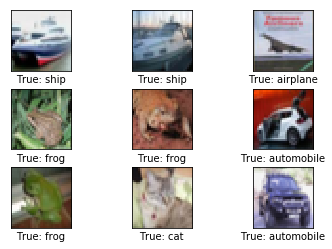

In [31]:
plot_images(images_test_for_print[1:10,:,:,:],cls_test_for_print[1:10], cls_pred=None, smooth=False)

In [32]:
images_train, cls_train, labels_train = load_training_data()
images_test, cls_test, labels_test = load_test_data()

Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_1
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_2
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_3
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_4
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_5
Loading data: data/CIFAR-10/cifar-10-batches-py/test_batch


In [33]:
# Check the data shape 
images_train.shape
images_test.shape
labels_train.shape   ##label_train and test_train is the one-hot coded label 
labels_test.shape

(50000, 32, 32, 3)

(10000, 32, 32, 3)

(50000, 10)

(10000, 10)

**Show the images after preprocessing**

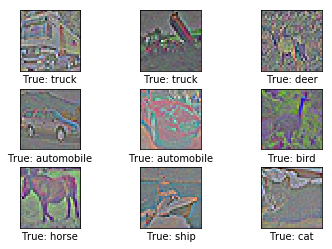

In [34]:
plot_images(images_train[1:10,:,:,:], cls_train[1:10], cls_pred=None, smooth=False)

## 3. Train the CNN Garph

In [ ]:
now = datetime.now()

dir_name = './CNN/log_{0}_{1}'.format(now.month,now.day)
export_dir = './CNN/savedmodel_{0}_{1}_{2}_{3}'.format(now.month,now.day,now.hour,now.second)

batch_size = 128
num_iterations = 20000
opt_method = 'adam'

## 4. Evaluate the CNN Graph

## 5. Train the NIN Graph

In [ ]:
now = datetime.now()

#dir_name = 'log_{0}_{1}'.format(now.month,now.day)
dir_name = 'log'
export_dir = 'savedmodel_{0}_{1}_{2}_{3}'.format(now.month,now.day,now.hour,now.second)

batch_size = 10
num_iterations = 100
opt_method = 'adam'

In [ ]:
builder = tf.saved_model.builder.SavedModelBuilder(export_dir)

with tf.Graph().as_default():
    
    global_step = tf.train.get_or_create_global_step()

    # Get images and labels for CIFAR-10.
    # Force input pipeline to CPU:0 to avoid operations sometimes ending up on
    # GPU and resulting in a slow down.
    
    with tf.device('/cpu:0'):
        # We build the model here as before
        x= tf.placeholder(tf.float32, shape=[None,32,32, num_channels], name='x')
        y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
        
        images = x
        images = pre_process(images=images, training=True)
        
        with tf.name_scope('model'):
            logits,conv1,cccp1,cccp2,pool1,conv2,pool2,cccp3,cccp4,conv3,cccp5,cccp6,pool3 = compute_logits_NIN(images)

            print('conv1:',conv1.shape,
                  'cccp1:',cccp1.shape,
                  'cccp2:',cccp2.shape,
                  'pool1:',pool1.shape,
                  'conv2:',conv2.shape,
                  'pool2:',pool2.shape,
                  'conv3:',conv3.shape,
                  'cccp5:',cccp5.shape)
            
        with tf.name_scope('loss'):
            loss = compute_cross_entropy(logits=logits, y=y_true)
        with tf.name_scope('accuracy'):
            accuracy = compute_accuracy(logits=logits, y=y_true)
            
        
        with tf.name_scope('opt'):   
            if opt_method == 'sgd':
                opt = tf.train.GradientDescentOptimizer(0.5)
            elif opt_method == 'rms':
                opt = tf.train.RMSPropOptimizer(.001)
            elif opt_method == 'adam':
                opt = tf.train.AdamOptimizer(1e-4)
            train_step = opt.minimize(loss)
                
        with tf.name_scope('summaries'):
            # create summary for loss and accuracy
            tf.summary.scalar('loss', loss) 
            tf.summary.scalar('accuracy', accuracy)
            # create summary for logits
            tf.summary.histogram('logits', logits)
            # create summary for input image
            tf.summary.image('input', tf.reshape(images, [-1,img_size_cropped,img_size_cropped, num_channels]))
            summary_op = tf.summary.merge_all()
    
        saver = tf.train.Saver()    ##Save the model
        
        sess = tf.Session()
    
        summary_writer = tf.summary.FileWriter(dir_name, sess.graph)
        summary_writer_train = tf.summary.FileWriter(dir_name+'/train', sess.graph)
        summary_writer_val = tf.summary.FileWriter(dir_name+'/val')
        
        sess.run(tf.global_variables_initializer())
    
        for i in range(num_iterations):
            X_batch, y_batch = random_batch()
            
            # now run
            _ , summary = sess.run((train_step, summary_op),
                                      feed_dict={x: X_batch, y_true: y_batch})
            
                
                # write the summary output to file
            if i%20==0:
                
                summary_writer_train.add_summary(summary, i)                    
                (train_error,train_logits) = sess.run((accuracy,logits), {x: X_batch, y_true: y_batch})
                 print("\rStep {0:3d}: training accuracy {1:0.4f}".format(i, train_error), flush=True)
                
                X_batch2 = images_test
                y_batch2 = labels_test
                (val_error, summary) = sess.run((accuracy,summary_op), {x:X_batch2, y_true:y_batch2})
                print("\rStep {0:3d}: val accuracy {1:0.4f}".format(i, val_error), flush=True)
                
                summary_writer_val.add_summary(summary, i)
                saver.save(sess, './model/model_iter', global_step=i)
                
        # Save the final model
        save_path = saver.save(sess, "./model/model.ckpt")
        builder.add_meta_graph_and_variables(sess,["foo-tag"])
builder.save()

## 6. Evaluate the CNN Graph

### 1. Show the shape of different layers

In [ ]:
conv1,cccp1,cccp2,pool1,conv2,pool2,cccp3,cccp4,conv3,cccp5,cccp6,pool3

### 2. Visualize the Conv Layers

In [ ]:
getActivations(sess,pool1,images_test)

In [36]:
#getActivations(sess,pool2,images_test)

### 3. Plot the confusion Matrix